In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from google.colab import files
from google.colab.patches import cv2_imshow



In [ ]:
# Set up the upload folder
UPLOAD_FOLDER = 'uploads'
MATCHED_FRAMES_FOLDER = 'matched_frames'
os.makedirs(UPLOAD_FOLDER, exist_ok=True)
os.makedirs(MATCHED_FRAMES_FOLDER, exist_ok=True)



In [ ]:
# Load the pre-trained InceptionV3 model
model = InceptionV3(weights='imagenet')
MAX_FILE_SIZE_MB = 10

def upload_video():
    uploaded = files.upload()
    for filename in uploaded.keys():
        file_size_mb = len(uploaded[filename]) / (1024 * 1024)
        if file_size_mb > MAX_FILE_SIZE_MB:
            raise ValueError(f"File size exceeds the {MAX_FILE_SIZE_MB}MB limit.")

        video_path = os.path.join(UPLOAD_FOLDER, filename)
        with open(video_path, 'wb') as f:
            f.write(uploaded[filename])
    return video_path





In [ ]:
def process_video(video_path, query):
    # Extract frames from the video
    frames = []
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
        frame_count += 1
    cap.release()
    print(f"Extracted {frame_count} frames from {video_path}")

    if not frames:
        raise ValueError("No frames extracted from video")

    # Predict objects in the frames
    predictions = []
    for i, frame in enumerate(frames):
        # Preprocess the frame
        frame_resized = cv2.resize(frame, (299, 299))
        frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
        frame_expanded = np.expand_dims(frame_rgb, axis=0)
        frame_preprocessed = preprocess_input(frame_expanded)

        # Make predictions
        preds = model.predict(frame_preprocessed)
        predictions.append(preds)
        print(f"Processed frame {i+1}/{len(frames)}")

    print("Predictions complete")

    # Search for the object in the predictions
    matched_frames = []
    matched_images = []
    for idx, preds in enumerate(predictions):
        decoded_preds = decode_predictions(preds, top=5)[0]
        print(f"Frame {idx+1} predictions: {decoded_preds}")
        for _, description, _ in decoded_preds:
            if query.lower() in description.lower():
                matched_frames.append(idx)
                matched_images.append(frames[idx])
                print(f"Match found: {description} in frame {idx+1}")
                break

    print(f"Found {len(matched_frames)} matched frames")

    if matched_frames:
        # Save the first matched frame
        matched_frame_path = os.path.join(MATCHED_FRAMES_FOLDER, 'matched_frame.jpg')
        cv2.imwrite(matched_frame_path, matched_images[0])
        return matched_frame_path
    else:
        raise ValueError("Object does not exist!!!")


Upload a video file


Saving v_Archery_g05_c05.avi to v_Archery_g05_c05.avi
Enter the object you want to search for: bow
Extracted 196 frames from uploads/v_Archery_g05_c05.avi
1/1 [==============================] - 1s 1s/step
Processed frame 1/196
1/1 [==============================] - 0s 27ms/step
Processed frame 2/196
1/1 [==============================] - 0s 25ms/step
Processed frame 3/196
1/1 [==============================] - 0s 24ms/step
Processed frame 4/196
1/1 [==============================] - 0s 23ms/step
Processed frame 5/196
1/1 [==============================] - 0s 24ms/step
Processed frame 6/196
1/1 [==============================] - 0s 33ms/step
Processed frame 7/196
1/1 [==============================] - 0s 26ms/step
Processed frame 8/196
1/1 [==============================] - 0s 24ms/step
Processed frame 9/196
1/1 [==============================] - 0s 23ms/step
Processed frame 10/196
1/1 [==============================] - 0s 22ms/step
Processed frame 11/196
1/1 [==========================

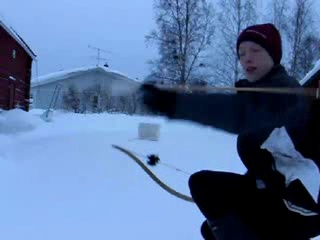

In [ ]:

def main():
    try:
        print("Upload a video file")
        video_path = upload_video()
        query = input("Enter the object you want to search for: ")
        matched_frame_path = process_video(video_path, query)
        print(f"Matched frame saved to {matched_frame_path}")
        matched_frame = cv2.imread(matched_frame_path)
        cv2_imshow(matched_frame)
    except Exception as e:
        print(f"Error occurred: {str(e)}")

if __name__ == '__main__':
    main()
